In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import tensorflow as tf
from typing import Tuple

Now that you understand how to get the data and model, you're ready to train the neural network. First, you need to load the data using the technique discussed in the first unit. In order not to clutter this notebook, we've added the get_data function and NeuralNetwork class you've already seen to a separate kintro.py file, which you import here.

In [2]:
from kintro import *

In order to understand what happens during training, you need to add a little more detail to our neural network visualization:

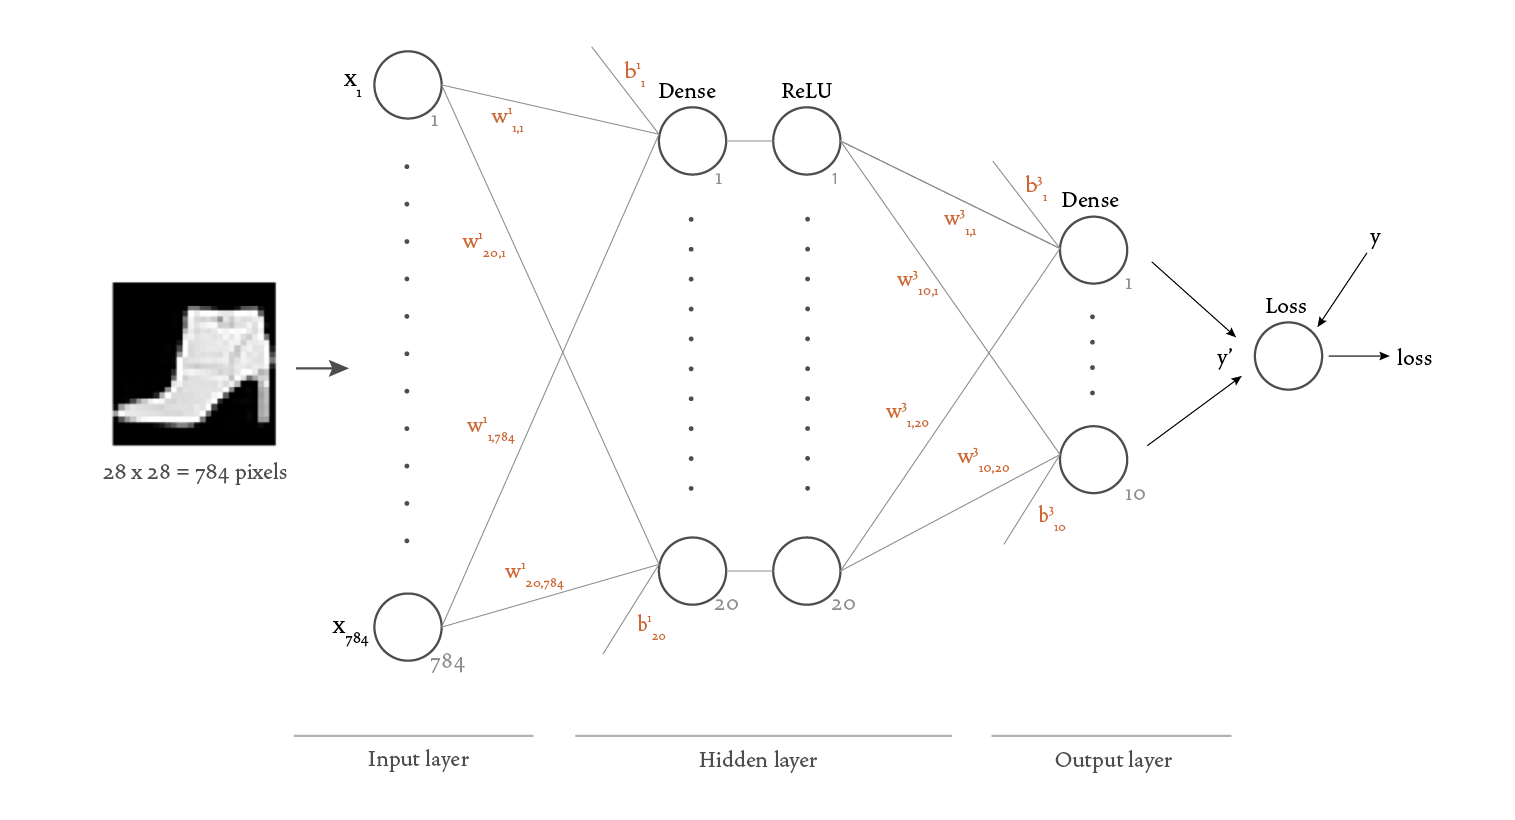

There's a lot of new information in this diagram, so let's expand on each of the new concepts here. 

Notice that you've added weights $W$ to the connections between layers, and bias $b$ as input to `Dense` layers. $W$ and $b$ are the neural network's parameters. Your goal when training your network (also known as fitting) is to find the parameters $W$ and $b$ that minimize the differences between the actual and predicted labels for your data. 

Notice also that we added a `Loss` function to the diagram. This function takes in the outputs of the model $y'$ (the predicted labels) and the actual labels $y$, measures their differences, and combines those into a single output, which we call the loss. The loss provides a single number that quantifies how similar your predictions are to the actual labels: a high loss indicates that they're different, and a low loss indicates that your predictions are accurate. The loss function most frequently used in classification is cross-entropy loss, and Keras provides several varieties of this loss. Because your dataset includes a single integer label for each example, use the [SparseCategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) loss function.

Now let's look at what happens in the `Dense` layers. `Dense` layers add a linear operation involving the input data and parameters $W$ and $b$. For example, the top node of the first `Dense` layer performs the following calculation:

$$
z^1_1 = w^1_{1,1} x_1 + ... + w^1_{1,784} x_{784} + b^1_1
$$

If you specify a ReLU activation function, the output of the linear operation is then passed as input to a ReLU function:

$$
a^1_1 = ReLU(z^1_1)
$$

Mathematically speaking, you can now think of our neural network as a function $\ell$ that takes as input the data $X$, expected labels $y$, and parameters $W$ and $b$, then performs a sequence of operations on that data, and returns a loss. 

$$
\mathrm{loss} = \ell(X, y, W, b)
$$

Your goal is to find the parameters $W$ and $b$ that lead to the lowest possible loss. (You can't change our data $X$ or the corresponding labels $y$ because they're fixed, but you can adjust $W$ and $b$.) It turns out that problems of this kind fall into the well-studied mathematical area of optimization. The simplest minimization algorithm is gradient descent, and this sample uses a variation known as [stochastic gradient descent or SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD). The training process is roughly as follows: First, the parameters $W$ and $b$ are initialized to random values. You then make predictions using those values, and evaluate the loss function to measure the quality of the predictions. And last, use the optimizer to adjust the values of $W$ and $b$ such that the loss will be a bit lower next time. Repeat this process until you've found parameters that give a very small loss value and good predictions.

You're now ready to *compile* the model. This is where you tell it that you want to use the `SGD` optimizer and the `SparseCategoricalCrossentropy` loss function. You also tell the model that you want it to report on the accuracy during training. 

In [13]:
learning_rate = 0.1
batch_size = 64

(train_dataset, test_dataset) = get_data(batch_size)

model = NeuralNetwork()

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate)
metrics = ['accuracy']
model.compile(optimizer, loss_fn, metrics)

A few details from the code above deserve a quick explanation. 

Notice that you pass `from_logits=True` to the loss function. This is because the categorical cross-entropy function requires a probability distribution as input, meaning that the numbers should be between zero and one, and they should add up to one. Your network produces a vector of numbers that have no upper or lower bound (called *logits*), so you need to normalize them to get a probability distribution. This is typically done using the `softmax` function, and specifying `from_logits=True` automatically calculates the softmax before computing the loss.

Notice also that you pass a `learning_rate` to the `SGD` optimizer. The learning rate is a parameter needed in the gradient descent algorithm. You could have left it at the default, which is 0.01, but it's important to know how to specify it because different learning rates can lead to very different prediction accuracies.

Finally, notice that we specified a `batch_size`, which you used in the construction of the `Dataset`, as you saw earlier. This is important during training, because it tells the model that you want to train on 64 images at a time. You might be wondering why 64? Why not train on a single image at a time? Or all 60,000 images at once? Doing a complete training step for each individual image would be inefficient because you would have to perform all the calculations 60,000 times in order to account for every input image. If you included all the input images in $X$, you'd need a lot of memory, and you'd spend a lot of time computing each training step. So we settle for a size in between, called the *mini-batch* size. 

Now that you've configured our model with the parameters you need for training, you can call `fit` to train the model. Specify the number of epochs as 5, which means that you want to iterate over the complete set of 60,000 training images five times while training the neural network.

In [14]:
for images, labels in train_dataset.take(1):
    print(images.dtype, labels.dtype)
    print(images.shape, labels.shape)


<dtype: 'float32'> <dtype: 'uint8'>
(64, 28, 28) (64,)


Training has found values for the parameters $W$ and $b$ such that, when you provide an image as input, you get a reasonable prediction as output. Your model is now ready to be tested. Remember that when you loaded the data, you obtained two datasets, one with training data and another with test data. It's time to use the test dataset.

In [16]:
print('\nEvaluating:')
(test_loss, test_accuracy) = model.evaluate(test_dataset)
print(f'\nTest accuracy: {test_accuracy * 100:>0.1f}%, test loss: {test_loss:>8f}')


Evaluating:


ValueError: dtype='string' is not a valid dtype for Keras type promotion.

You've achieved pretty good test accuracy, considering that you used such a simple network and only five epochs of training. You're done with training and can now save the model.

In [ ]:
model.save('outputs/model')

Now that your neural network has appropriate values for its parameters, you can use it to make a prediction.